# Traffic Sign Recognition (GTSRB Datasets)






## Introduction

Identifying and correctly interpreting traffic signs is essential for any self-driving or driver assistance system in modern vehicles. For this project, we'll be using the GTSRB (Stallkamp et al.) datasets (http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) to develop a classifier to correctly identify the German traffic signs in 43 classes.

One advantage of dealing with traffic signs is that their shape and colors remain mostly consistent.  However, factors such as brighness, weather conditions (e.g. rain, fog) and motion can have major impacts on the final image. 






## Imports

In [0]:
from google.colab import drive
import numpy as np
from skimage import io
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import h5py
import pickle
import csv
import matplotlib.pyplot as plt
import pandas as pd
import itertools

from keras.models import Model, Sequential
from keras.layers import (
    Input,
    Conv2D,MaxPooling2D,ZeroPadding2D,
    concatenate, add, Activation,
    Dense,Flatten,Dropout
)
from keras.optimizers import Adam, SGD
from keras import regularizers
from keras import backend as K
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import (
    ReduceLROnPlateau,
    Callback, 
    History
)
from keras.models import load_model

In [0]:
# Mount Google Drive to the current Colab VM Runtime
drive.mount('/content/Google_Drive')

# Remove sample_data that comes with a new Colab Notebook
! rm -rdf sample_data

Drive already mounted at /content/Google_Drive; to attempt to forcibly remount, call drive.mount("/content/Google_Drive", force_remount=True).


## Setup

Since our workflow was based off Google Drive and Google Colab, we ran into some issues with bottlenecks w/ image IO. Our dataset consists of 51839 images of different sizes, loading them all into memory was a slow proces.

To fix this issue, we first extracted the sign from our images using the provided bounded box and then downsize them to  a consistent size. We locally preprocessed each image and then combined them into a h5py numpy array. We based our size, 42x42, off the paper Yin et. Al as it showed promising results. This reduced our data IO cost by a large factor, while also ensuring that we are able to use all the available images.

In [0]:
# Actual Labels

label_names = ['Max 20',                        #0
               'Max 30'                         #1
               'Max 50',                        #2
               'max 60',                        #3
               'Max 70',                        #4
               'Max 80',                        #5
               'End Max 80',                    #6
               'Max 100',                       #7
               'Max 120',                       #8
               'No Overtaking Any',             #9
               'No Overtaking Truck',           #10
               'Through Traffic Priority'       #11
               'Priority',                      #12
               'Yield',                         #13
               'Stop',                          #14
               'No Vehicle Any',                #15
               'No Truck Permitted',            #16
               'No Enter',                      #17
               'Danger Point',                  #18
               'Danger Curve Left',             #19
               'Danger Curve Right',            #20
               'Double Curves Left First',      #21
               'Bumpy Road',                    #22 
               'Slippery Road',                 #23
               'Road Narrows Right',            #24
               'Road Construction',             #25
               'Traffic Signals',               #26
               'Pedestrian Crossing',           #27
               'Children Crossing',             #28
               'Bicycle Lane',                  #29
               'Snow/Ice',                      #30
               'Wild Animal',                   #31
               'Previous Limit End',            #32
               'Must Turn Right',               #33
               'Must Turn Left',                #34
               'Must Go Straight',              #35
               'Must Go Straight or Left',      #36
               'Must Go Straight or Right',     #37
               'Keep Right of Barrier',         #38
               'Keep Left of Barrier',          #39
               'Roundabout',                    #40
               'End No Overtaking Any',         #41
               'End No Overtaking Truck']       #42  

In [0]:
# Read images from google drive. Output to file.
dont run will override

def readTrafficSigns(path_in, path_out, pics_per_class=None, crop=False, verbose=1):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example './GTSRB/Training/Images/'
    Returns:   list of images, list of corresponding labels'''
    
    # loop over all 43 classes csv files
    classes = []
    labels  = []
    for c in range(0,43):
        prefix = path_in + '/' + format(c, '05d') + '/' 
        csvPath = prefix + 'GT-'+ format(c, '05d') + '.csv' 
        csvFileDataFrame = pd.read_csv(csvPath, sep=';')
        images_per_class = []
        labels_per_class = []	
        for img_file_name, x1, x2, y1, y2, label in zip(list(csvFileDataFrame['Filename']), list(csvFileDataFrame['Roi.X1']), list(csvFileDataFrame['Roi.X2']), list(csvFileDataFrame['Roi.Y1']), list(csvFileDataFrame['Roi.Y2']), list(csvFileDataFrame['ClassId'])):
            img = io.imread(prefix + img_file_name)
            if pics_per_class is not None:
                if len(images_per_class)==pics_per_class:
                    break 
            if crop:
                img = img[x1:x2, y1:y2]
            img = np.array(img,dtype='float')
            img = transform.resize(img,(48,48,3),
                                   preserve_range=True,
                                   anti_aliasing=True,
                                   mode='reflect')
            images_per_class.append(img)
            labels_per_class.append(label)
        classes.append(np.asarray(images_per_class))
        labels = labels + labels_per_class
        if verbose==1:
            print('class {}/43 completed'.format(c+1)) 
    if verbose==1:
        print("Total Number of Classes is " + str(len(classes)))
        max_img_count_per_class = 0
        min_img_count_per_class = 9999 
        iter = 1
        for Class in classes:
            max_img_count_per_class = max(max_img_count_per_class, Class.shape[0])
            min_img_count_per_class = min(min_img_count_per_class, Class.shape[0])
            print("Class " + str(iter) + " has shape " + str(Class.shape) )
            iter+=1
        print('Max number of images in a training class is: ' + str(max_img_count_per_class))
        print('Min number of images in a training class is: ' + str(min_img_count_per_class))
    labels = np.asarray(labels, dtype='int') 
    classes = np.concatenate(classes, axis=0)

    with h5py.File(path_out+'/Training.h5', 'w') as hf:
        hf.create_dataset('train_imgs', data=classes)
        hf.create_dataset('train_labels', data=labels)
    if verbose==1:
        print("Results saved in " + path_out + "/Training.h5")
    return classes, labels


training_path = '/Users/Aang/CS484/Training/Images'
output_path = '/Users/Aang/CS484/Training'
classes, labels = readTrafficSigns(training_path,
                                   output_path,
                                   pics_per_class=None,
                                   crop=True,
                                   verbose=1)

In [0]:
# Method to get image based off its index

def get_test_img(index):
    parent_dir = 'Google_Drive/My Drive/GTSRB/Test/Images'
    imdir = (parent_dir + '/' + format(index, '05d') +'.ppm')
    img = io.imread(imdir)
    return img

In [0]:
# Load the training and testing data from the file

# Here the data has been extracted from the corect training and testing p5 files 
# DONT UPDATE OR CHANGE
path = 'Google_Drive/My Drive/GTSRB/'
X_Train, Y_Train, X_Test, Y_Test = None, None, None, None

with h5py.File(path + 'Training/Training.h5', 'r') as hf:
    X_Train,Y_Train = hf['train_imgs'][:], hf['train_labels'][:]
print("Loaded images from Train.h5")

with h5py.File(path + 'Test/Test.h5', 'r') as hf:
    X_Test,Y_Test = hf['test_imgs'][:], hf['test_labels'][:]
print("Loaded images from Test.h5")

Loaded images from Train.h5
Loaded images from Test.h5


## Data Exploration and Analysis

The data set contains 39209 training images and 12630 test image with 43 categories. The sizes of the images vary between 15x15 to 250x250 pixels. In addition to this, they are not neccessarily squared nor centered.

Upon further analysis, the images are not distributed evenly throughout the classes, as shown below.




In [0]:
n_classes = 43

In [0]:
classes, counts = np.unique(Y_Train, return_counts=True)

print('mean: {}'.format(sum(counts)/n_classes))
print('range:{}-{}'.format(min(counts), max(counts)))

mean: 911.8372093023256
range:210-2250


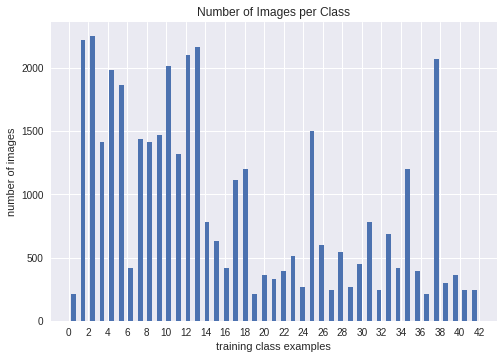

In [0]:
# Labels histogram

plt.figure(1)

plt.xticks(np.arange(0,43,step=2))
plt.hist(Y_Train, bins=n_classes, rwidth=0.5,  orientation='vertical')
plt.ylabel('number of images')
plt.xlabel('training class examples')
plt.title('Number of Images per Class')
plt.show()


The images per class range from 210-2250, which is a substantial difference. We explore ways of mitigating this issue in iteration 2.

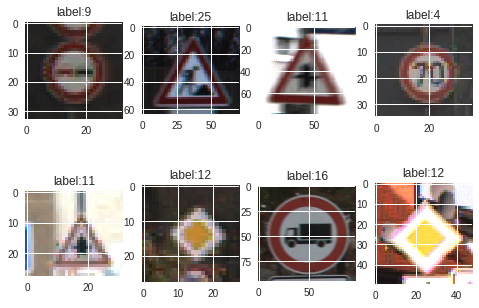

In [0]:
# Show some images -> Images below are 48 * 48 * 3 hence appear pixelated

demo_indeces = np.random.choice(len(Y_Test), 8, replace=False)

plt.figure(2) 
for i in range(8):
    plt.subplot(2,4,i+1) 
    img = get_test_img(demo_indeces[i])
    plt.imshow(img)
    plt.title('label:{}'.format(Y_Test[demo_indeces[i]]))
        
plt.show()

## General Methods 

In [0]:
# Create callbacks to track detailed history.

class Train_Loss_vs_Epochs(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))

class Train_Accuracy_vs_Epochs(Callback):
    def on_train_begin(self, logs={}):
        self.accs = []

    def on_epoch_end(self, epoch, logs={}):
        self.accs.append(logs.get('acc'))
        
class Val_Loss_vs_Epochs(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('val_loss'))
        
class Val_Accuracy_vs_Epochs(Callback):
    def on_train_begin(self, logs={}):
        self.accs = []

    def on_epoch_end(self, epoch, logs={}):
        self.accs.append(logs.get('val_acc'))

## Iteration 1 
For out initial iteration, we rely on a simple model to set our threshold. To do so, we utilize the VGG11 architecture. The advantage of the VGG11 architecture is that it is simple to implement and relativlely quick to train. 

The data we have is ordered by classes, so we employ shuffling when preprocessing technique when training to make our model more robust. We also normalize our image data.



In [0]:
def get_vg11_model():
    num_classes = 43
    input_shape = (48,48,3)
    epochs = 18
    
    batch_size = 32
    model = Sequential()
    
    model.add( Conv2D(64, (3,3), activation='relu',
    input_shape=input_shape, padding='same') )
    model.add( MaxPooling2D((2,2), strides=(2,2)) )
    
    model.add( Conv2D(128, (3,3), activation='relu', padding='same') )
    model.add( MaxPooling2D((2,2), strides=(2,2)) )
    
    model.add( Conv2D(256,(3,3), activation='relu', padding='same') )
    model.add( Conv2D(256,(3,3), activation='relu', padding='same') )
    model.add( MaxPooling2D((2,2), strides=(2,2)) )
    
    model.add( Conv2D(512,(3,3), activation='relu', padding='same') )
    model.add( Conv2D(512,(3,3), activation='relu', padding='same') )
    model.add( MaxPooling2D((2,2), strides=(2,2)) )
    
    model.add( Conv2D(512,(3,3), activation='relu', padding='same') )
    model.add( Conv2D(512,(3,3), activation='relu', padding='same') )
    model.add( MaxPooling2D((2,2), strides=(2,2)) )
    
    model.add( Flatten() )
    model.add( Dense(4096, activation='relu') )
    model.add( Dense(4096, activation='relu') )
    model.add( Dense(1000, activation='relu') )
    
    model.add( Dense(num_classes, activation='softmax') )
    
    sgd = SGD(0.001, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

In [0]:
Train_Loss_Hist0 = Train_Loss_vs_Epochs()
Train_Acc_Hist0 = Train_Accuracy_vs_Epochs()
Val_Loss_Hist0 = Val_Loss_vs_Epochs()
Val_Acc_Hist0 = Val_Accuracy_vs_Epochs()

model = get_vg11_model()

In [0]:
# Normalize
X_Train_Norm =  X_Train/255
X_Test_Norm = X_Test/255
        
Y_Train_Cat = to_categorical(Y_Train, 43)
Y_Test_Cat = to_categorical(Y_Test, 43)

history = model.fit(x=X_Train_Norm, y=Y_Train_Cat, 
                    batch_size=128, epochs=18, 
                    verbose=1, callbacks=[
                        ReduceLROnPlateau(monitor='val_acc', 
                                          factor=0.1,
                                          patience=0, 
                                          verbose=1,
                                          mode='max',
                                          min_delta=1e-3, 
                                          cooldown=0, 
                                          min_lr=1e-7),
                        Train_Loss_Hist0, 
                        Train_Acc_Hist0,
                        Val_Loss_Hist0,
                        Val_Acc_Hist0], 
                    validation_data=(X_Test_Norm, Y_Test_Cat), 
                    shuffle=True)

model.save_weights('vgg11model2_weights.h5')

Train on 39209 samples, validate on 12630 samples
Epoch 1/18
39209/39209 [==============================] - 57s 1ms/step - loss: 1.7963 - acc: 0.5266 - val_loss: 1.4373 - val_acc: 0.6611
Epoch 2/18
39209/39209 [==============================] - 54s 1ms/step - loss: 0.3559 - acc: 0.9100 - val_loss: 0.8520 - val_acc: 0.8381
Epoch 3/18
39209/39209 [==============================] - 54s 1ms/step - loss: 0.1515 - acc: 0.9629 - val_loss: 0.6449 - val_acc: 0.8821
Epoch 4/18
39209/39209 [==============================] - 54s 1ms/step - loss: 0.0857 - acc: 0.9796 - val_loss: 0.5259 - val_acc: 0.9066
Epoch 5/18
39209/39209 [==============================] - 54s 1ms/step - loss: 0.0537 - acc: 0.9875 - val_loss: 0.5435 - val_acc: 0.9156
Epoch 6/18
39209/39209 [==============================] - 54s 1ms/step - loss: 0.0385 - acc: 0.9911 - val_loss: 0.5543 - val_acc: 0.9146

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/18
39209/39209 [======================

In [0]:
model.save_weights('vgg11model_weights.h5')

In [0]:
score = model.evaluate(X_Test_Norm, Y_Test_Cat, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5112083454526406
Test accuracy: 0.930087094238988


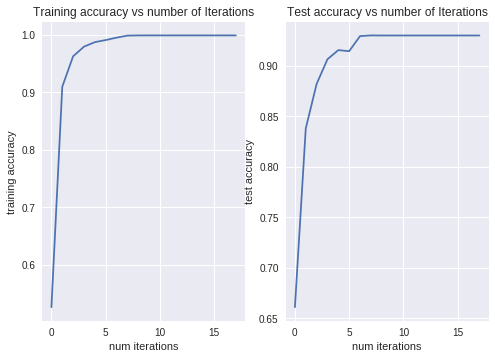

In [0]:
# Test accuracy vs number of iterations

plt.figure(3) 

plt.subplot(1,2,1)
plt.plot(history.history['acc'])
plt.title("Training accuracy vs number of Iterations")
plt.ylabel("training accuracy")
plt.xlabel("num iterations")

plt.subplot(1,2,2)
plt.plot(history.history['val_acc'])
plt.title("Test accuracy vs number of Iterations")
plt.ylabel("test accuracy")
plt.xlabel("num iterations")
plt.show()

In [0]:
Y_Predicted = model.predict_classes(X_Test_Norm)

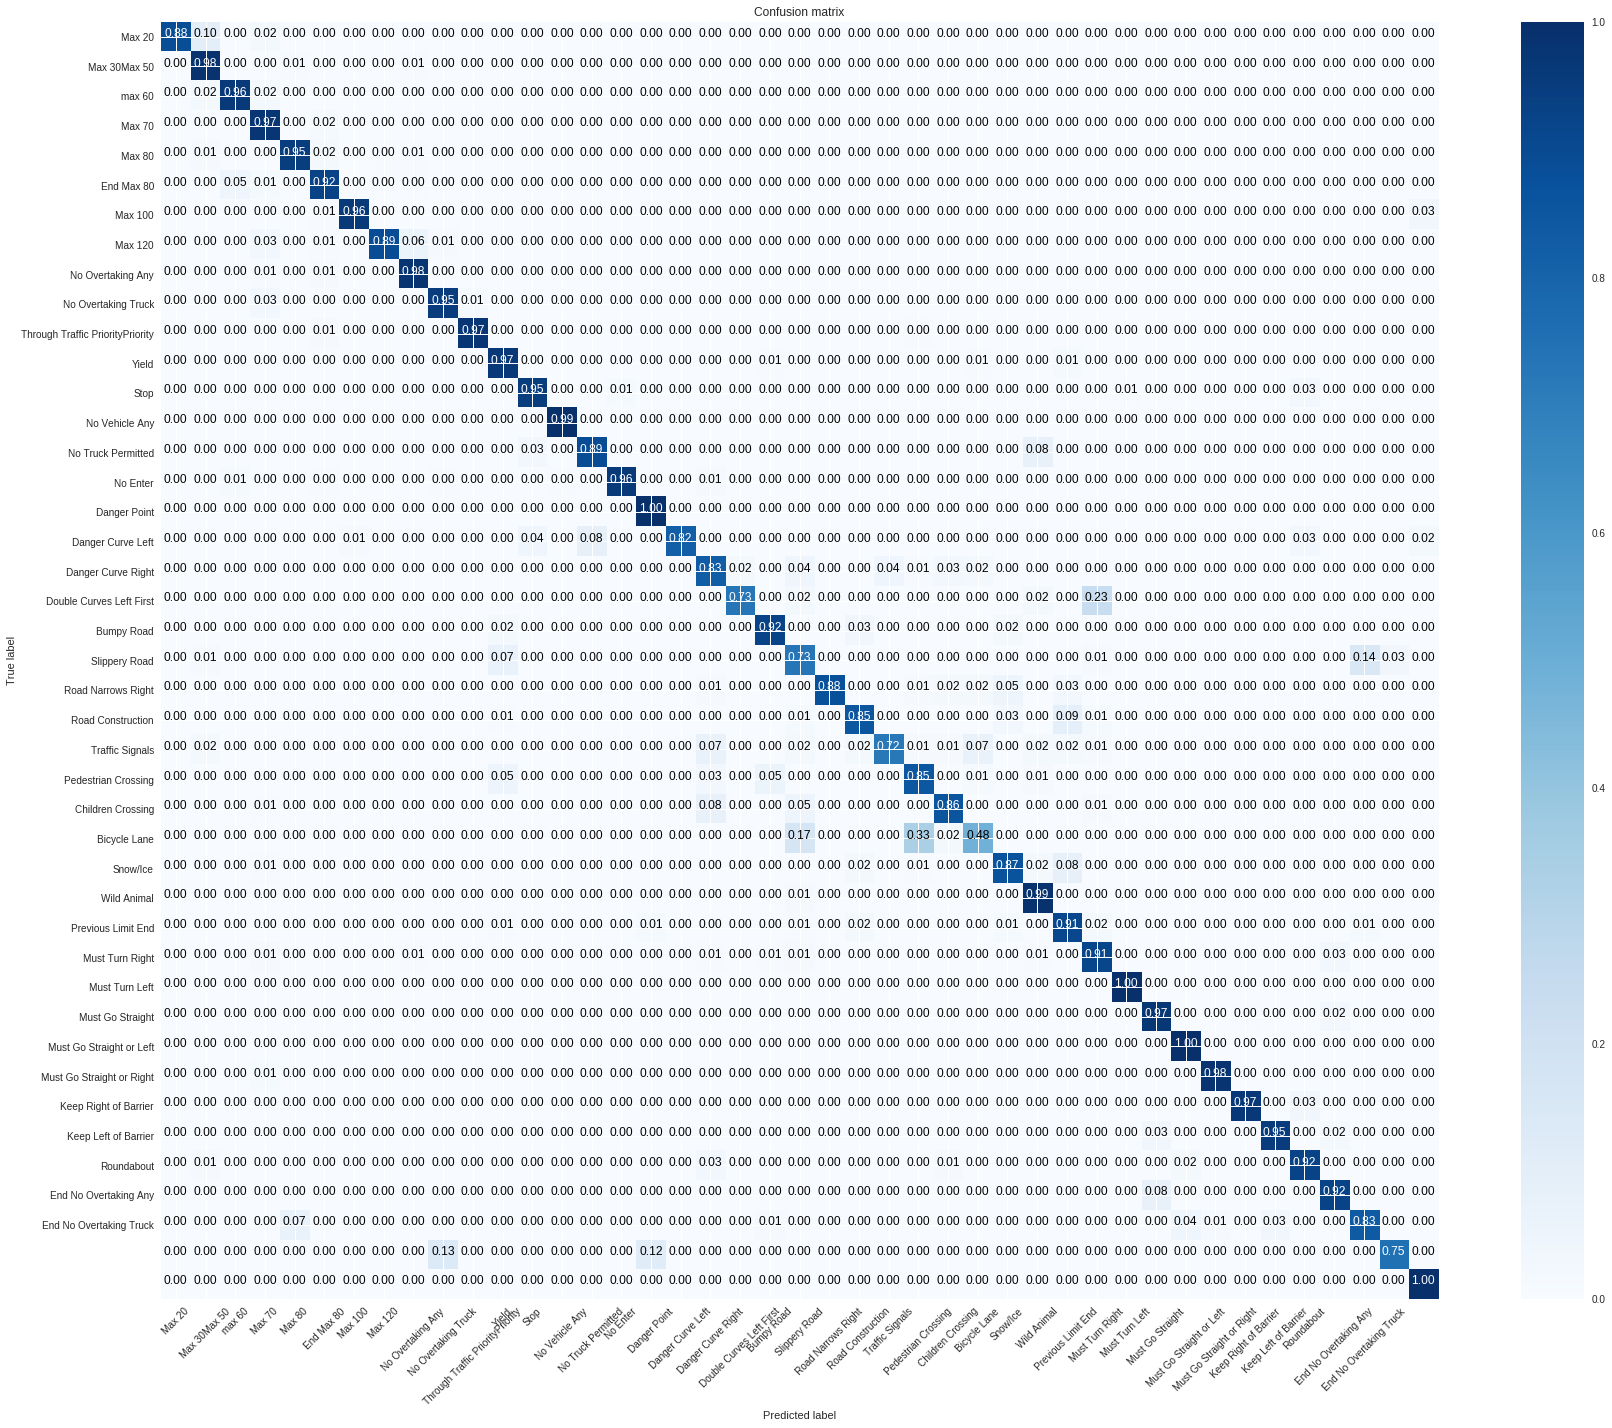

In [0]:
# Show confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    [Sklearn example]
    """
    f = plt.figure(4, figsize=(25,20))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
        pass
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
cm = confusion_matrix(Y_Test, Y_Predicted)
plot_confusion_matrix(cm, label_names,normalize=True)

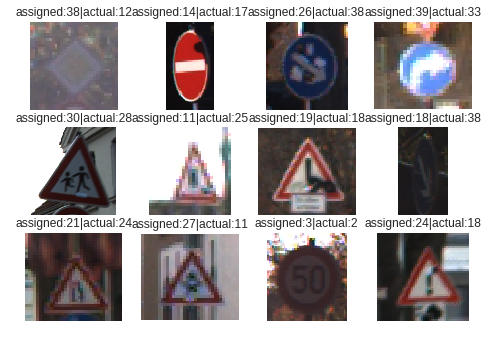

In [0]:
mismatch_at = np.where(Y_Predicted != Y_Test)[0]
demo_mismatches = np.random.choice(mismatch_at, 12, replace=False)

plt.figure(4) 
for i in range(12):
    plt.subplot(3,4,i+1) 
    img = get_test_img(demo_mismatches[i])
    plt.imshow(img)
    plt.title('assigned:{}|actual:{}'.format(
        Y_Predicted[demo_mismatches[i]],
        Y_Test[demo_mismatches[i]]))                                           
    plt.axis('off')   
plt.show()

### Analysis

The VGG11 model fits quickly; however, its test accuracy converges to around 93%.

Looking at some of the mismatched images above, we can see why they were mislabelled. One of the major issues is brightness: excessive light and darkness both greatly affect the final accuracy of the model. Furthermore, transformations such as shearing (as in image 2), rotations (image 5) also appear to be possible causes of error. Lastly, it's apparent that the classes with less images are more likely to be mislabelled.

## Iteration 2

For our second iteration, we employ a more advanced architecture based on the paper by Yin et al., which will be referred to as YINTSR henceforth.

The paper introduces a novel structure that combines network-in-network and residual connections. SELUs are used as activation fuctions since they have self-normalizing properties. 

We attempt to reduce overfitting in our model by augmenting our data. In our Data Exploration and Analysis section, we discovered that our data was not uniformly distrubuted over our 43 classes. To mitigate this, we augment images in each class so we get the same number of images per class, 2250. 

To maximize accuracy, we base our augmentations on how our images of traffic signs differ. For example, the same sign could be translated horizontally or vertically, rotated etc. 

We preprocess our images by resizing them to 48x48 and by linearly scaling them to acheive zero mean and unit norm and  as outlined by Yin et al. Furthermore, we shuffle our images to make our model more robust. We also reduce the learning rate when test acc plateaus while training the model to get better results.

In [0]:
def get_augmented_data(X, Y):
    aug = ImageDataGenerator(rotation_range=45,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.2,
                         zoom_range=0.2,
                         fill_mode='nearest'
                        )  
    begin = 0
    X_Train = []
    Y_Train = []
    for Class in range(43):
        num = np.sum(np.array(Y==(Class+1)))
        X_temp = X[begin:begin+num]
        Y_temp = Y[begin:begin+num]
        num_to_augment = 2250 - num
        if(num_to_augment>0):
            X_aug = []
            for im in aug.flow(x=X_temp,batch_size=1,shuffle=True):
                X_aug.append(im)
                num_to_augment = num_to_augment - 1

                if num_to_augment<=0:
                    break
            X_aug = np.concatenate(X_aug,axis=0)
            X_temp = np.concatenate([X_temp, X_aug])
            Y_temp = np.append(Y_temp, np.full((X_aug.shape[0]),Class+1))
        X_Train.append(X_temp)
        Y_Train.append(Y_temp)
        begin+=num
    X_Train = np.concatenate(X_Train,axis=0)
    Y_Train = np.concatenate(Y_Train,axis=0)

    return X_Train, Y_Train

In [0]:
def Block_Layer(Tensor):
    D=Tensor.shape[-1].value

    Branch1 = Conv2D(32,(1,1),
                     strides=1,
                     padding='same',
                     data_format="channels_last",
                     activation='selu',
                     use_bias=True,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='zeros',
                     kernel_regularizer=regularizers.l2(0.0005))(Tensor)
    
    Branch2 = Conv2D(32,(1,1),
                     strides=1,
                     padding='same',
                     data_format="channels_last",
                     activation='selu',
                     use_bias=True,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='zeros',
                     kernel_regularizer=regularizers.l2(0.0005))(Tensor)
    Branch2 = Conv2D(64,(5,5),
                     strides=1,
                     padding='same',
                     data_format="channels_last",
                     activation='selu',
                     use_bias=True,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='zeros',
                     kernel_regularizer=regularizers.l2(0.0005))(Branch2)
    
    Branch3 = Conv2D(64,(1,1),
                     strides=1,
                     padding='same',
                     data_format="channels_last",
                     activation='selu',
                     use_bias=True,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='zeros',
                     kernel_regularizer=regularizers.l2(0.0005))(Tensor)
    Branch3 = Conv2D(128,(3,3),
                     strides=1,
                     padding='same',
                     data_format="channels_last",
                     activation='selu',
                     use_bias=True,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='zeros',
                     kernel_regularizer=regularizers.l2(0.0005))(Branch3)

    Branch4 = MaxPooling2D(pool_size=(3,3),
                           strides=1,
                           padding='same',
                           data_format="channels_last")(Tensor)
    Branch4 = Conv2D(32,(1,1),
                     strides=1,
                     padding='same',
                     data_format="channels_last",
                     activation='selu',
                     use_bias=True,
                     kernel_initializer='glorot_uniform',
                     bias_initializer='zeros',
                     kernel_regularizer=regularizers.l2(0.0005))(Branch4)
    
    DepthConcat = concatenate([Branch1,Branch2,Branch3,Branch4],axis=-1)
    
    Fx = Conv2D(D,(1,1),
                strides=1,
                padding='same',
                data_format="channels_last",
                activation='selu',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=regularizers.l2(0.0005))(DepthConcat)
    
    Tensor = add([Fx,Tensor])
    return Tensor

In [0]:
def create_tsr_model():
    # Setup Layers
    C1 = Conv2D(64,(7,7),
                strides=1,
                padding='same',
                data_format="channels_last",
                activation='selu',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=regularizers.l2(0.0005))


    C3 = Conv2D(128,(5,5),
                strides=1,
                padding='same',
                activation='selu',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=regularizers.l2(0.0005))

    M3 = MaxPooling2D(pool_size=(3,3),
                      strides=2,
                      data_format="channels_last")

    C5 = Conv2D(256,(3,3),
                strides=1,
                padding='same',
                activation='selu',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=regularizers.l2(0.0005))

    M5 = MaxPooling2D(pool_size=(3,3),
                      strides=2,
                      data_format="channels_last")

    C7 = Conv2D(256,(3,3),
                strides=1,
                padding='same',
                data_format="channels_last",
                activation='selu',
                use_bias=True,
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros',
                kernel_regularizer=regularizers.l2(0.0005))

    M7 = MaxPooling2D(pool_size=(3,3),
                      strides=2,
                      data_format="channels_last")

    FC8 = Dense(512,
                activation='selu',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros')


    FC9 = Dense(512,
                activation='selu',
                kernel_initializer='glorot_uniform',
                bias_initializer='zeros')

    FC10 = Dense(43, activation='softmax')
    
    # Put them together
    Input_Tensor = Input(shape=(48,48,3))
    Tensor = C1(Input_Tensor)
    Tensor = Block_Layer(Tensor) #B2
    Tensor = C3(Tensor) 
    Tensor = M3(Tensor) 
    Tensor = Block_Layer(Tensor) #B4
    Tensor = C5(Tensor)
    Tensor = M5(Tensor)
    Tensor = Block_Layer(Tensor) #B6
    Tensor = C7(Tensor)
    Tensor = M7(Tensor)
    Tensor = Flatten()(Tensor)
    Tensor = FC8(Tensor)     
    Tensor = Dropout(0.5)(Tensor)
    Tensor = FC9(Tensor)      
    Tensor = Dropout(0.5)(Tensor)
    Output_Tensor = FC10(Tensor)
    
    # Create model
    model=Model(inputs=Input_Tensor, outputs=Output_Tensor)
    model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [0]:
model = create_tsr_model()

In [0]:
model.get_config()

plot_model(model, to_file='Block_Layer_Net_Model.png',
           show_shapes=True,
           show_layer_names=True)

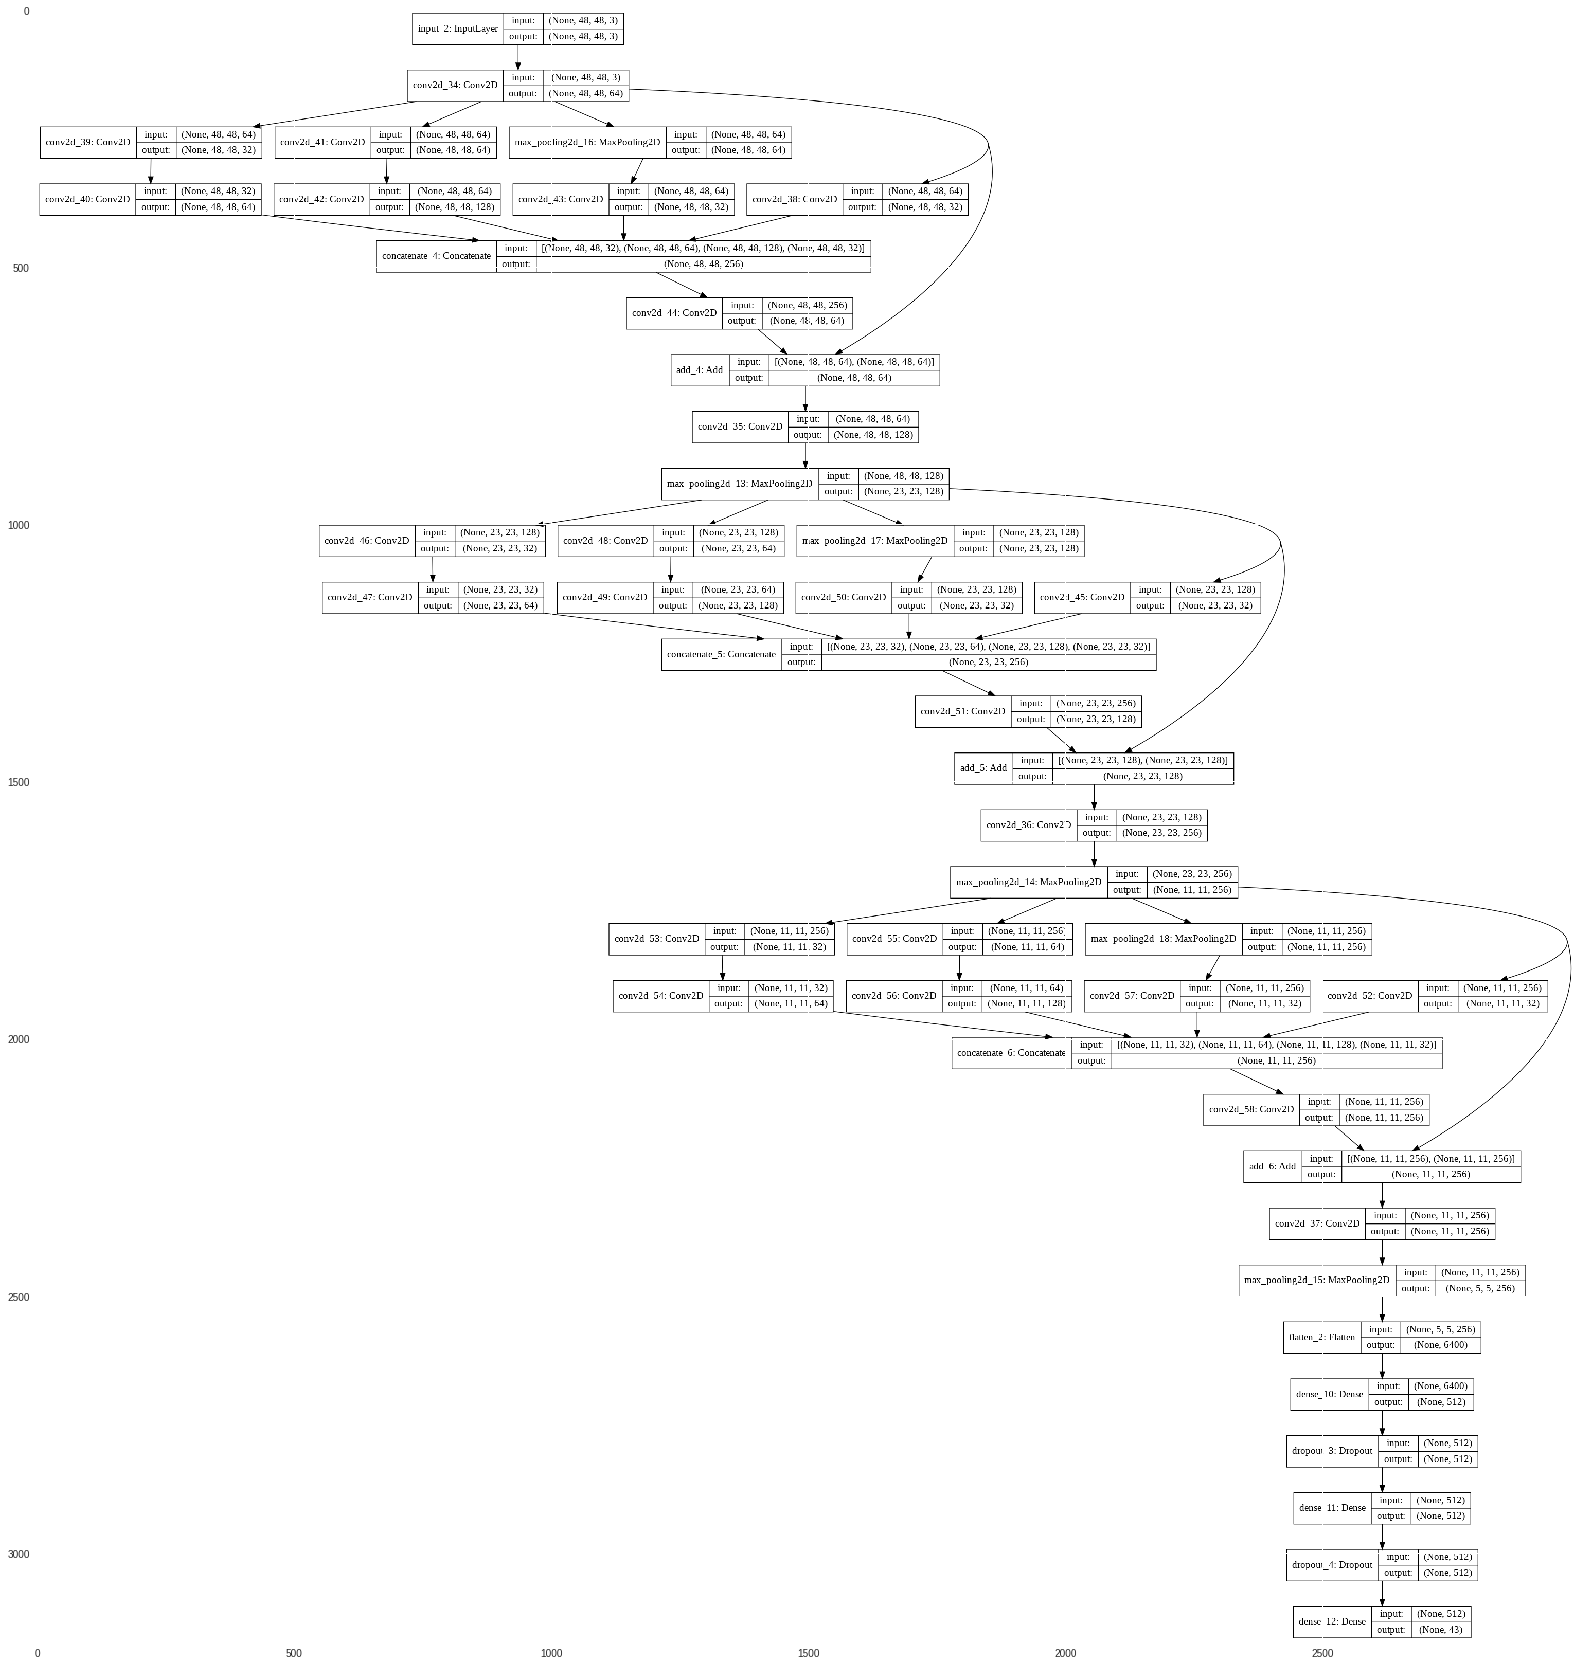

In [0]:
path = 'Google_Drive/My Drive/'
arch = io.imread(path + 'Block_Layer_Net_Model.png')
plt.figure(5,  figsize=(70,30))
plt.imshow(arch, )
plt.show()

In [0]:
X_TrainAug, Y_TrainAug = get_augmented_data(X_Train, Y_Train)

In [0]:
# Preprocessing with zero mean and unit norm

def unit_norm(X_img):
    for ind in range(X_img.shape[0]):
        X_img[ind] = (X_img[ind]-X_img[ind].mean())/X_img[ind].std()
    return X_img

X_Train_UNorm = unit_norm(X_Train)

In [0]:

Train_Loss_Hist = Train_Loss_vs_Epochs()
Train_Acc_Hist = Train_Accuracy_vs_Epochs()
Val_Loss_Hist = Val_Loss_vs_Epochs()
Val_Acc_Hist = Val_Accuracy_vs_Epochs()


history = model.fit(x=X_Train_UNorm, y=Y_Train_Cat, 
                    batch_size=128, epochs=18, 
                    verbose=1, callbacks=[
                        ReduceLROnPlateau(monitor='val_acc', 
                                          factor=0.1,
                                          patience=0, 
                                          verbose=1,
                                          mode='max',
                                          min_delta=1e-3, 
                                          cooldown=0, 
                                          min_lr=1e-7),
                        Train_Loss_Hist, 
                        Train_Acc_Hist,
                        Val_Loss_Hist,
                        Val_Acc_Hist], 
                    validation_split=0.2, 
                    shuffle=True)


Train on 77400 samples, validate on 19350 samples
Epoch 1/18
77400/77400 [==============================] - 459s 6ms/step - loss: 3.2113 - acc: 0.4864 - val_loss: 1.6244 - val_acc: 0.8351
Epoch 2/18
77400/77400 [==============================] - 452s 6ms/step - loss: 1.8879 - acc: 0.7763 - val_loss: 1.3040 - val_acc: 0.9282
Epoch 3/18
77400/77400 [==============================] - 452s 6ms/step - loss: 1.5068 - acc: 0.8722 - val_loss: 1.1879 - val_acc: 0.9576
Epoch 4/18
77400/77400 [==============================] - 452s 6ms/step - loss: 1.3232 - acc: 0.9205 - val_loss: 1.1572 - val_acc: 0.9655
Epoch 5/18
77400/77400 [==============================] - 451s 6ms/step - loss: 1.2396 - acc: 0.9405 - val_loss: 1.1025 - val_acc: 0.9775
Epoch 6/18
77400/77400 [==============================] - 451s 6ms/step - loss: 1.1796 - acc: 0.9549 - val_loss: 1.0876 - val_acc: 0.9795
Epoch 7/18
77400/77400 [==============================] - 450s 6ms/step - loss: 1.1415 - acc: 0.9624 - val_loss: 1.0666 - 

In [0]:
# Save the final model
dont run
model.save_weights('model_weights.h5')
model.save("model.h5")
model_json = model.to_json()
           
with open('model.json', 'w') as outfile:
    json.dump(model_json, outfile)

with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [0]:
# Load model

path = 'Google_Drive/My Drive/model_weights.h5'
model.load_weights(path)

### Analysis

In [0]:
# Evaluate on test data
X_Test_UNorm = unit_norm(X_Test)

score = model.evaluate(x=X_Test_UNorm, y=Y_Test_Cat, batch_size=30, verbose=1)

In [0]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.094141309448206
Test accuracy: 0.986563727345999


In [0]:
Y_PredictedProbs = model.predict(X_Test_UNorm)
Y_Predicted = np.argmax(Y_PredictedProbs,axis=1)

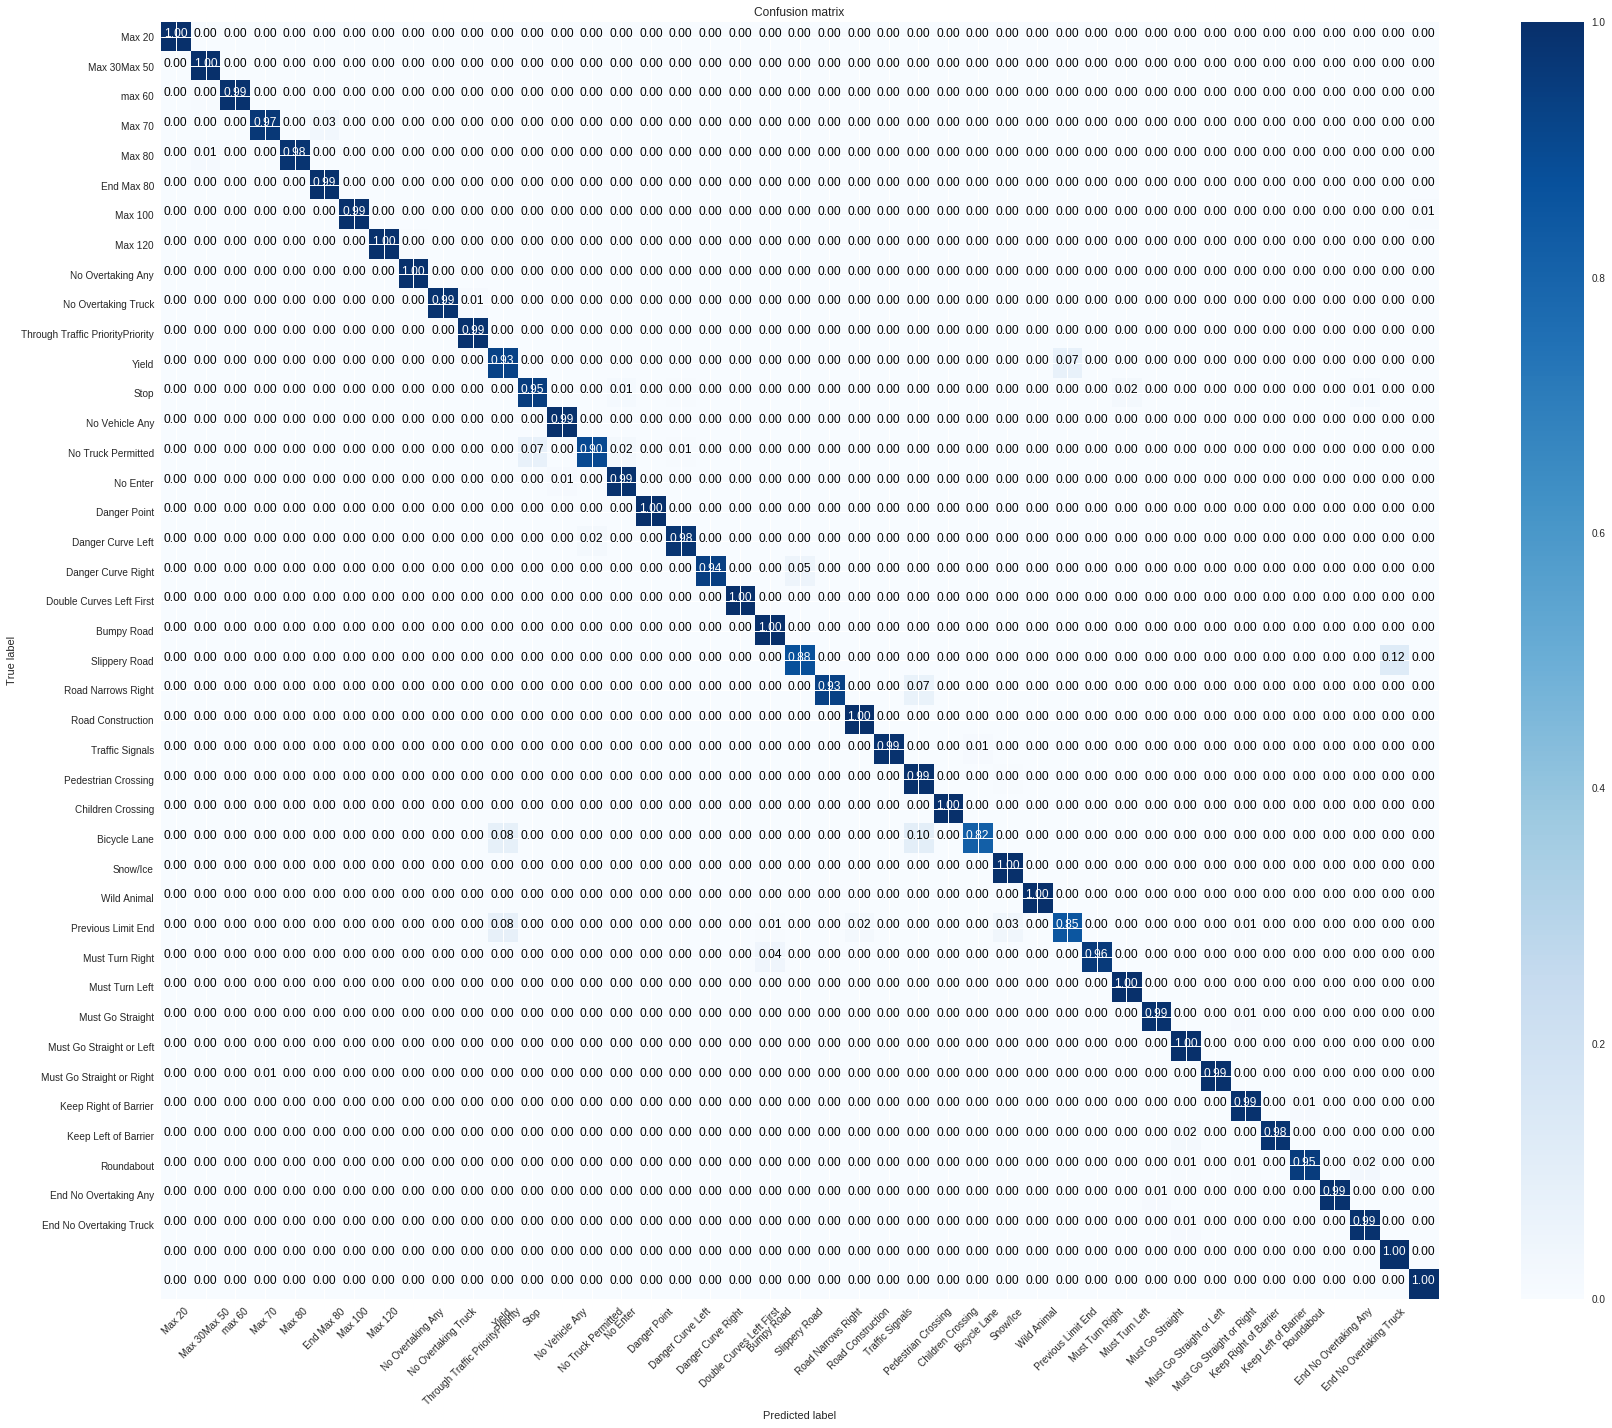

In [0]:
cm2 = confusion_matrix(Y_Test, Y_Predicted)
plot_confusion_matrix(cm2, label_names,normalize=True)

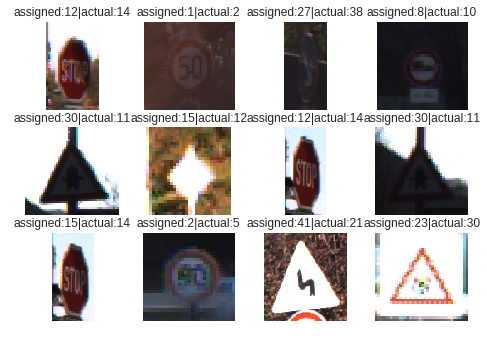

In [0]:
mismatch_at = np.where(Y_Predicted != Y_Test)[0]
demo_mismatches = np.random.choice(mismatch_at, 12, replace=False)

plt.figure(8) 
for i in range(12):
    plt.subplot(3,4,i+1) 
    img = get_test_img(demo_mismatches[i])
    plt.imshow(img)
    plt.title('assigned:{}|actual:{}'.format(
        Y_Predicted[demo_mismatches[i]],
        Y_Test[demo_mismatches[i]]))                                           
    plt.axis('off')   
plt.show()

We obtain a final accuracy of 98.6% with the YINSTR model! We also note that our loss was also still steadily decreasing, implying that we could have obtained even better results if we had trained for more epochs.  

Looking at the images above that were misclassified, it's clear that some of them would be difficult or even impossible to accuractely classify by a human. For the others, it's clear that sharp angles and brightness still have a major impact on the our predictions.



## Conclusion

The performace of the Block-Layered Net (YINTSR model) proposed by YIN et al, which combines the concepts of Network-in-Network(Inception Module) and Residual Connection, clearly exceeds the performance of VGG11, a VGGnet of roughly the same depth.
Intuitively, we believe this is because the three block-layers in this model capture details of the previous layer at various scales by using convolutional filters of different sizes, while, in comparison, a VGGnet only extracts a single level of feature at a layer. Moreover, as the depth of a CNN increases, the deepest hierarchies of abstraction gets limited by only the knowledge of the previous layer, yet sometimes a better abstraction is hidden not only in the previous layer but from many other layers prior to it, thus Residual Connection is able to help reduce the loss of information from any of the lower layers and add passthrough routing so that layers receive more detailed information. However, while the performance of the YINTSR model definitely exceeds that of other state-of-the-art models for traffic sign recognition (Yin et Al), the main issue we encountered with the YINTSR architecture was that it took a substantial amount of time to built and train, even with a GPU. 

Given more time, we would explore methods alternate methods of brighness correction and training for transformatinons such as shears as they seem to have a large impact on the accuracies of our predictions. Lastly, we'd also like to explore alternate methods of acheiving similar accuracies while simplifying the layers.  


## References

        J. Stallkamp, M. Schlipsing, J. Salmen, and C. Igel. The German Traffic Sign Recognition Benchmark: A multi-class classification competition. In Proceedings of the IEEE International Joint Conference on Neural Networks, pages 1453–1460. 2011. 
      
        Kim, J., Lee, J. K., & Lee, K. M. (2016). Accurate Image Super-Resolution Using Very Deep Convolutional Networks. 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR). doi:10.1109/cvpr.2016.182
      
        Yin S., Deng J., Zhang D., Du J. (2017) Traffic Sign Recognition Based on Deep Convolutional Neural Network. In: Yang J. et al. (eds) Computer Vision. CCCV 2017. Communications in Computer and Information Science, vol 771. Springer, Singapore
    